In [7]:
import os
from dotenv import load_dotenv
from langchain_ollama import OllamaEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_ollama.llms import OllamaLLM

load_dotenv()

# langsmith setup
os.environ['LANGSMITH_TRACING']=os.getenv('LANGSMITH_TRACING')
os.environ['LANGSMITH_API_KEY']=os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_ENDPOINT']=os.getenv('LANGSMITH_ENDPOINT')
os.environ['LANGSMITH_PROJECT']=os.getenv('LANGSMITH_PROJECT')

In [8]:
# llm model
# Initialize the Ollama LLM with the desired model
llm = OllamaLLM(model="llama3.2")

In [3]:
# embedding model
embeddings = OllamaEmbeddings(
    model="llama3.2",
)

# pdf files path
file_path = "../data/main.pdf"

pdf_loader = PyPDFLoader(file_path=file_path)

docs = pdf_loader.load()

# print(f"{docs[0].page_content[:500]}\n")

# setting up text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True
)

# splitting all pages from entire document
all_splits = text_splitter.split_documents(docs)

# setting up vector store
vector_store = Chroma(embedding_function=embeddings, 
                      collection_name='chroma_db',
                      persist_directory='../data/chroma_db')
# ids = vector_store.add_documents(documents=all_splits)
ids = vector_store.add_documents(documents=all_splits)

In [25]:
template = """You are an expert for the scientific paper writing and question answering from the content of scientific papers given in context. Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate(template=template,
                                   input_variables=['context', 'question'])

In [26]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

chain = (
    {'context': vector_store.as_retriever(), 'question': RunnablePassthrough()}
    | custom_rag_prompt
    | llm
    | StrOutputParser()
)

In [29]:
response = chain.invoke("Is it possible to write literature review in better way?")

In [30]:
print(response)

It appears that the provided documents are not a scientific paper but rather a source document with figures and tables. Without more context, I'm unable to provide guidance on writing a literature review. The content seems to be a general introduction or an outline of the document, without specific information on research findings or conclusions.

Don't know.

Thanks for asking!


In [ ]:
# # define state for app
# class State(TypedDict):
#     question: str
#     context: List[Document]
#     answer: str

# # define app steps
# def retrieve(state: State):
#     retrieved_docs = vector_store.similarity_search(state["question"])
#     return {"context": retrieved_docs}

# def generate(state: State):
#     docs_content = "\n\n".join(doc.page_content for doc in state["context"])
#     messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
#     response = llm.invoke(messages)
#     return {"answer": response.content}

In [ ]:
# # Compile application and test
# graph_builder = StateGraph(State).add_sequence([retrieve, generate])
# graph_builder.add_edge(START, "retrieve")
# graph = graph_builder.compile()

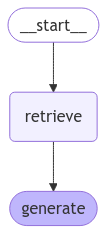

In [ ]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))